In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import time
import numpy as np
import cv2
import pickle

import numpy
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation

from utils.printProgressBar import printProgressBar

def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()

def getNumTrainParms(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

%matplotlib notebook

In [2]:
# READ IN THE TRAINING DATA:

f = open('robo_data_persp.pickle', 'rb')
dat = pickle.load(f)
IMG = dat['IMG']
v_left = dat['LEFT_V']
v_right = dat['RIGHT_V']

trgRes = (32, 32)
for i in range(len(IMG)):
    IMG[i] = cv2.resize(IMG[i], dsize=trgRes, interpolation=cv2.INTER_AREA)
    
print('Samples in vis. input: {}'.format(IMG.__len__()))
print('Shape of visual input: {}'.format(IMG[0].shape))

print('Shape of right speeds: {}'.format(v_right.__len__()))
print('Shape of left  speeds: {}'.format(v_left.__len__()))

Samples in vis. input: 824
Shape of visual input: (32, 32, 3)
Shape of right speeds: 824
Shape of left  speeds: 824


In [3]:
# prep the data:

v_right = dat['RIGHT_V']
v_left = dat['LEFT_V']
img = np.stack(IMG)
img = img.transpose(0,3,1,2)
img = img[:,0,:,:]
img = img[:,None, :,:]
visual_input = torch.tensor(img, dtype=torch.float)

visual_target = np.roll(visual_input, -1, axis=0)
visual_target = torch.tensor(visual_target, dtype=torch.float)

target_v_right = np.roll(v_right, -1, axis=0)
target_v_left  = np.roll(v_left, -1, axis=0)

v_right = torch.tensor(v_right, dtype=torch.float).view(-1,1)
v_left = torch.tensor(v_left, dtype=torch.float).view(-1,1)

target_v_right = torch.tensor(target_v_right, dtype=torch.float).view(-1,1)
target_v_left = torch.tensor(target_v_left, dtype=torch.float).view(-1,1)

motor_input = torch.cat((v_right, v_left), dim=1)
motor_target = torch.cat((target_v_right, target_v_left), dim=1)


print('Visual input shape: {}'.format(img.shape))
print('Visual target shape: {}'.format(visual_target.shape))
print('Motor target shape: {}'.format(motor_target.shape))

# check in the inputs have really been rolled as needed:
print([torch.sum(visual_input[i+1] - visual_target[i]).item() for i in range(10)])
print([torch.sum(motor_input[i+1] - motor_target[i]).item() for i in range(10)])

Visual input shape: (824, 1, 32, 32)
Visual target shape: torch.Size([824, 1, 32, 32])
Motor target shape: torch.Size([824, 2])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


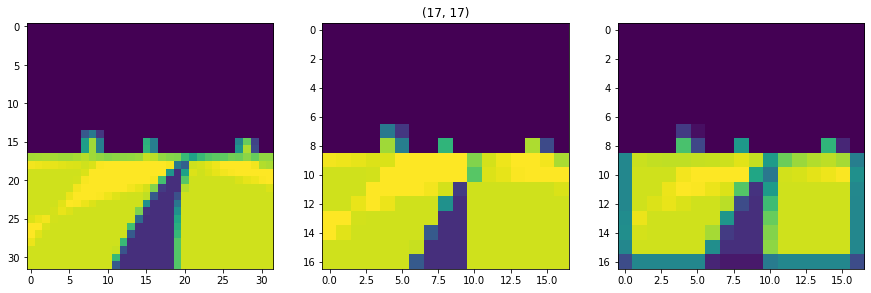

In [4]:
%matplotlib inline
# us1 =   nn.Upsample(scale_factor=10, mode='nearest', align_corners=None)
us1 =   nn.MaxPool2d(2, stride=2, padding=1)
us2 =   nn.AvgPool2d(2, stride=2, padding=1)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(visual_input[1].squeeze().detach().numpy())
plt.subplot(1,3,2)
x = us1(visual_input[1].unsqueeze(0)).squeeze().detach().numpy()
x1 = us2(visual_input[1].unsqueeze(0)).squeeze().detach().numpy()
plt.imshow(x)
plt.title(x.shape)

plt.subplot(1,3,3)
plt.imshow(x1)

In [5]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size):
        super(RNN, self).__init__()                  # extend the functionality of previously built classes.
        self.hidden_size = hidden_size
        self.cell_type = cell_type
        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)

        self.conv1 = nn.Conv2d(1, 7, kernel_size=3, padding=(1,1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(7, 28, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 =   nn.Linear(1792, 100)
        self.fc2 =   nn.Linear(100, 10)
        self.fc3 =   nn.Linear(12, 2) # latent video (10) + motor (2) output from RNN to motor prediction
        self.fc4 =   nn.Linear(12, 64)
        self.us1 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us2 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us3 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us4 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.conv3 = nn.Conv2d(1, 10, 3, padding=1)
        self.conv4 = nn.Conv2d(10, 1, 3, padding=1)
        self.activate = nn.Tanh()
        self.optimizer = optim.RMSprop(self.parameters(),
                                       lr=0.001,
                                       momentum=0.00,
                                       weight_decay=0.000,
                                       centered=False)
        
        
    def forward(self, visual_input, motor_input, hidden):
        
        # visual pathway:
        out = F.relu(self.conv1(visual_input))
        out = self.pool1(out)
        out = F.relu(self.conv2(out)) # torch.Size([1367, 15, 58, 58])
        out = self.pool2(out)         # torch.Size([1367, 15, 28, 28])
        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3]) # flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        # concatenate visual pathway and motor input:
        out = torch.cat((out, motor_input), dim=1).unsqueeze_(1) # unsqueeze adds a dimension (for batch=1) inplace
        
        # run this combined input through an RNN cell (to predict the next visual input and motor state):
        out, hidden = self.rnn_cell(out, hidden)
        
        # predict motor output based on the latent representation:
        motor_output = F.relu(self.fc3(out.squeeze()))
        
        # reconstruct video from the latent representation:
        out1 = F.relu(self.fc4(out.squeeze()))
        out1 = out1.view(-1,1,8,8)
        out1 = self.us1(out1)
        out1 = F.relu(self.conv3(out1))
        out1 = self.us2(out1)
        out1 = F.relu(self.conv4(out1))

        return out1, motor_output, hidden

    def initHidden(self):
        if self.cell_type=='LSTM': # we initialize a 2-tuple of hidden states (hidden state, memory)
            return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        if self.cell_type=='GRU' or self.cell_type=='RNN': # we initialize a hidden state
            return torch.zeros(1, 1, self.hidden_size)

In [6]:
# rnn.optimizer.zero_grad()
# hidden = rnn.initHidden()
# out, hidden = rnn(visual_input, motor_input, hidden)

In [7]:
input_size  = 12
hidden_size = 12
output_size = 12
cell_type = 'GRU'

EPOCHS = 5000

criterion = nn.MSELoss()

rnn = RNN(cell_type, input_size, hidden_size, output_size)


# For optimal results, see when motor loss stops decreasing, interrupt the training, increase the weight of the motor loss and continue training

In [10]:
LOSS = []
printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 50)
for epoch in range(EPOCHS):
    rnn.optimizer.zero_grad()
    hidden = rnn.initHidden() # re-init hidden state to zero
    visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)
    motor_loss = 1 * criterion(motor_output, motor_target)
    visual_loss = criterion(visual_output, visual_target)
    loss = motor_loss + visual_loss
    loss.backward()
    LOSS.append(loss.item())
    rnn.optimizer.step()
    printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.2f} mloss: {:.2f} Progress: '.format(
        epoch, visual_loss.item(), motor_loss.item()), suffix='Complete', length=50)
    

Epoch: 12 vloss: 12741.60 mloss: 54.06 Progress:  |--------------------------------------------------| 0.3% Complete

KeyboardInterrupt: 